In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
plt.style.use('ggplot')

In [237]:
!ls data

national_footprint_data.csv


In [238]:
footprint_df = pd.read_csv('data/national_footprint_data.csv')

In [239]:
footprint_df['country'].unique().size

196

In [240]:
footprint_df['year'].unique().size

54

In [241]:
footprint_df['UN_region'].unique().size

7

In [242]:
footprint_df['UN_subregion'].unique().size

23

Our dataset spans 54 years and included 196 total countries

## Business Understanding 1 -- 10
* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

Data set taken from https://www.kaggle.com/footprintnetwork/national-footprint-accounts-2018.

"In this data set we show results for 196 countries (including "World") for data years 1961 through 2014, the most recent year with complete data. For each country and year, we report Ecological Footprint of Consumption, also just called Ecological Footprint, and Biocapacity ("Biocap...","EFCons...") as well as Ecological Footprint of Production ("EFProd...") and trade ("EFImports...", "EFExports...") in both total global hectares and global hectares per capita ("...TotGHA","...PerCap")."

The original purpose of this data set was to track the Ecological Footprints of the countries as time went on. We are going to use this data to cluster similar countries to each other. 

* This Dataset Tracks data using 10 methods for each year across as many of the 196 Countries that data can be collected for. Those 10 methods are...

>* BioCapPerCap: Biocapacity in global hectares (gha) divided by population

>* BiocapTotGHA: Total biocapacity in global hectares (gha)

>* EFConsPerCap: Ecological Footprint of consumption in global hectares (gha) divided by population

>* EFConsTotGHA: Total Ecological Footprint of consumption in global hectares (gha)

>* Human Development Index (HDI): HDI = Human Development Index; Source: Trends in the Human Development Index, 1980-2014, downloaded 2/24/2017 from http://hdr.undp.org/en/composite/trends

>* Gross Domestic Product (GDP): Gross Domestic Product per capita, current prices; Source: World Economic Outlook database - by countries, downloaded 2/24/2017 from http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/download.aspx

>* Data Quality Score: Quality of overall country data as assessed by NFA researchers. For more detail, seehttp://www.footprintnetwork.org/data-quality-scores/

## Data Understanding 1 --10
* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [243]:
footprint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 15 columns):
country                     87020 non-null object
ISO alpha-3 code            85660 non-null object
UN_region                   87020 non-null object
UN_subregion                87020 non-null object
year                        87020 non-null int64
record                      87020 non-null object
crop_land                   63530 non-null float64
grazing_land                63530 non-null float64
forest_land                 63530 non-null float64
fishing_ground              63530 non-null float64
built_up_land               63530 non-null float64
carbon                      63530 non-null float64
total                       87020 non-null float64
Percapita GDP (2010 USD)    71410 non-null float64
population                  87020 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 10.0+ MB


In [244]:
footprint_df['record'].unique()

array(['BiocapPerCap', 'BiocapTotGHA', 'EFConsPerCap', 'EFConsTotGHA',
       'EFExportsPerCap', 'EFExportsTotGHA', 'EFImportsPerCap',
       'EFImportsTotGHA', 'EFProdPerCap', 'EFProdTotGHA'], dtype=object)

* It Apears that some values were left as NA because they were not recorded in those countries on the given year.  Using the value of built_up_land as an example, can see that the value remains N/A for some countries in all cases

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


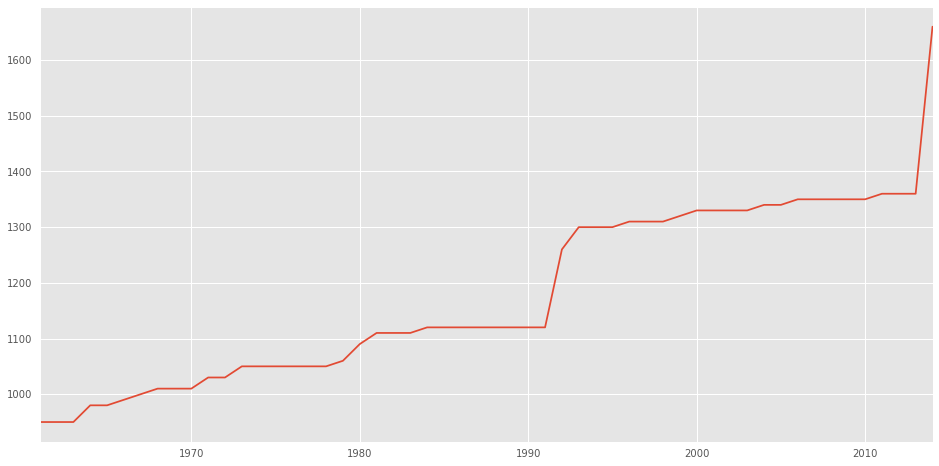

In [245]:
footprint_df[footprint_df['built_up_land'].fillna('NA') != 'NA']['year']\
    .value_counts().sort_index().plot(figsize=(16, 8))

In [246]:
cp_foot = footprint_df.copy()
cp_foot['bum'] = cp_foot['built_up_land'].fillna('NA').apply(lambda x: 0 if x == 'NA' else 1)

cp_grp = cp_foot.groupby('country').agg({'bum' : max})
print('{} countries have no data on built_up_land\n'.format(cp_grp[cp_grp['bum'] == 0].index.size))
print('They Are...')
for i in cp_grp[cp_grp['bum'] == 0].index:
    print("{} {} Population: {:.3f} Million".format(i,
          " " * (31 - len(i)),
          footprint_df.query("country == '{}' & year == {}"\
                             .format(i,
                                     cp_foot.query("country == '" + i + "'")['year'].max()))\
                            ['population'].values[0] / 1000000))

27 countries have no data on built_up_land

They Are...
Antigua and Barbuda              Population: 0.091 Million
Aruba                            Population: 0.103 Million
Bermuda                          Population: 0.062 Million
Cabo Verde                       Population: 0.514 Million
Cambodia                         Population: 15.328 Million
Cayman Islands                   Population: 0.059 Million
Comoros                          Population: 0.770 Million
Cook Islands                     Population: 0.021 Million
Cyprus                           Population: 1.154 Million
Czechoslovakia                   Population: 15.651 Million
Dominica                         Population: 0.072 Million
Egypt                            Population: 89.580 Million
Ethiopia PDR                     Population: 54.763 Million
Grenada                          Population: 0.106 Million
Honduras                         Population: 7.962 Million
Kiribati                         Population: 0.110 Mill

* For Ethiopia PDR, the USSR, Czechoslovakia and Yugoslav SFR Records ended because the country no longer exists

In [247]:
(cp_foot.groupby('country').agg({'bum' : min})['bum'] == 0).sum()

56

* 56 Countries are missing built_up_land for at least one year

In [248]:
cp_grp = (cp_foot.groupby('country').agg({'bum' : min})['bum'] == 1)
complete_data_countries = set(cp_grp[cp_grp].index)
cp_grp.sum()

140

* 140 total countries have complete data for the built_up_land column

In [249]:
def get_complete_set(cat):
    cp_foot['bum'] = cp_foot[cat].fillna('NA').apply(lambda x: 0 if x == 'NA' else 1)
    return set((cp_foot.groupby('country').agg({'bum' : min})['bum'] == 1).index)

for i in footprint_df.columns[6:]:
    if len(complete_data_countries - get_complete_set(i)) > 0:
        print(i, "-- is missing", 
              ", ".join(list(complete_data_countries - get_complete_set(i))),
              "\n")

In [250]:
for i in footprint_df.columns[6:]:
    print(i)

crop_land
grazing_land
forest_land
fishing_ground
built_up_land
carbon
total
Percapita GDP (2010 USD)
population


* Missing data is consistant across all of the missing columns listed above.  
* Since these columns could be considered valuable to our clustering problem, we will focus only on the 140 countries which maintained good records for all values for now; allthough it is worth pointing out that countries which did not record any of these values likley have some traits in common

In [251]:
only_complete = footprint_df[footprint_df['country'].isin(complete_data_countries)]

In [252]:
only_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63240 entries, 0 to 87019
Data columns (total 15 columns):
country                     63240 non-null object
ISO alpha-3 code            62200 non-null object
UN_region                   63240 non-null object
UN_subregion                63240 non-null object
year                        63240 non-null int64
record                      63240 non-null object
crop_land                   63240 non-null float64
grazing_land                63240 non-null float64
forest_land                 63240 non-null float64
fishing_ground              63240 non-null float64
built_up_land               63240 non-null float64
carbon                      63240 non-null float64
total                       63240 non-null float64
Percapita GDP (2010 USD)    54590 non-null float64
population                  63240 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 7.7+ MB


## Data Understanding 2 -- 	10
* Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [253]:
c2014 = only_complete[only_complete['year'] == 2014]

* for a start, we are only going to focus on PerCap statistics (meaning we will normalize the size of each country) In order to reduce each country in a given year to a single row, we will also reduce all the land variables to Production, Consumption, Imports and Exports and normalize each of these values by total land capacity

In [254]:
t_df = only_complete.set_index(['country', 'year']).iloc[:,3:-2]

In [255]:
rec_name = 'Exports'

In [256]:
t_df['record'].unique()

array(['BiocapPerCap', 'BiocapTotGHA', 'EFConsPerCap', 'EFConsTotGHA',
       'EFExportsPerCap', 'EFExportsTotGHA', 'EFImportsPerCap',
       'EFImportsTotGHA', 'EFProdPerCap', 'EFProdTotGHA'], dtype=object)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


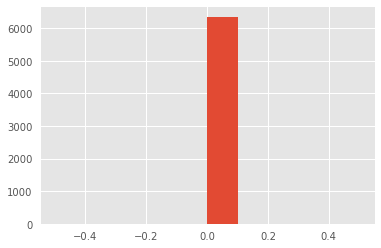

In [257]:
footprint_df[footprint_df['record'] == 'EF{}PerCap'.format(rec_name)]['built_up_land'].hist()

In [258]:
out_lst = []
for rec_name in ['Cons', 'Prod', 'Exports', 'Imports']:
    p_df = t_df[t_df['record'] == 'EF{}PerCap'.format(rec_name)].iloc[:,1:]
    p_df.columns = ["{}_".format(rec_name[:4].lower()) + x for x  in p_df.columns]
    out_lst.append(p_df)
pivoted_df = pd.concat(out_lst, axis=1)

In [259]:
## this one runs a bit slow
rel_cols = only_complete.columns[[2, 3, -2, -1]].tolist()
pivoted_df[rel_cols] = only_complete.groupby(['country', 'year']).max()[rel_cols]

In [260]:
full_df = pivoted_df.reset_index()

* now we will take a snapshot of a single year and see where many of the datapoints land

In [261]:
c2014 = full_df[full_df['year'] == 2014]

In [262]:
c_base = c2014.iloc[:,2:-4]

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


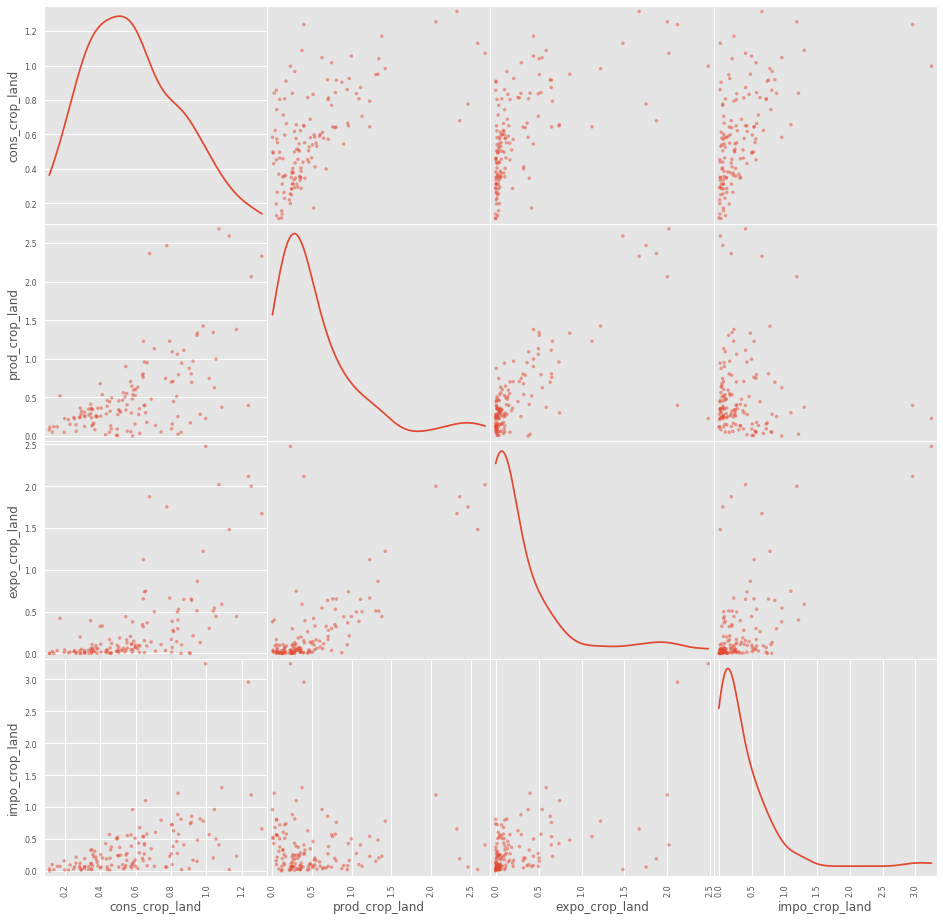

In [263]:
pd.plotting.scatter_matrix(
    c_base[[x for x in c_base.columns if x.split('_')[1] == 'crop']], 
    diagonal='kde',
    figsize=(16,16));

In [264]:
c2014.sort_values('prod_crop_land', ascending=False)\
    [[x for x in c2014.columns if x[5:9] == 'crop' or x == 'country']].head(9)

,country,cons_crop_land,prod_crop_land,expo_crop_land,impo_crop_land
918,Canada,1.071039,2.680990,2.017042,0.407091
238,Argentina,1.129334,2.588882,1.481689,0.022140
4170,Paraguay,0.776197,2.466455,1.751534,0.061276
292,Australia,0.679401,2.362183,1.872301,0.189519
3188,Lithuania,1.313572,2.326516,1.670907,0.657964
1477,Denmark,1.253463,2.061550,1.998803,1.190716
2920,Latvia,0.981874,1.423207,1.221598,0.780266
1554,Belarus,1.170548,1.380207,0.440327,0.230668
5715,United States of America,1.039327,1.341758,0.505336,0.202906


* The trend in crop land indicates that that; while many countries produce crops at a rate that is sustainable, there is a cluster of countries which consume more then they produce, and there is a small group of  6 countries which produce far more then they consume.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


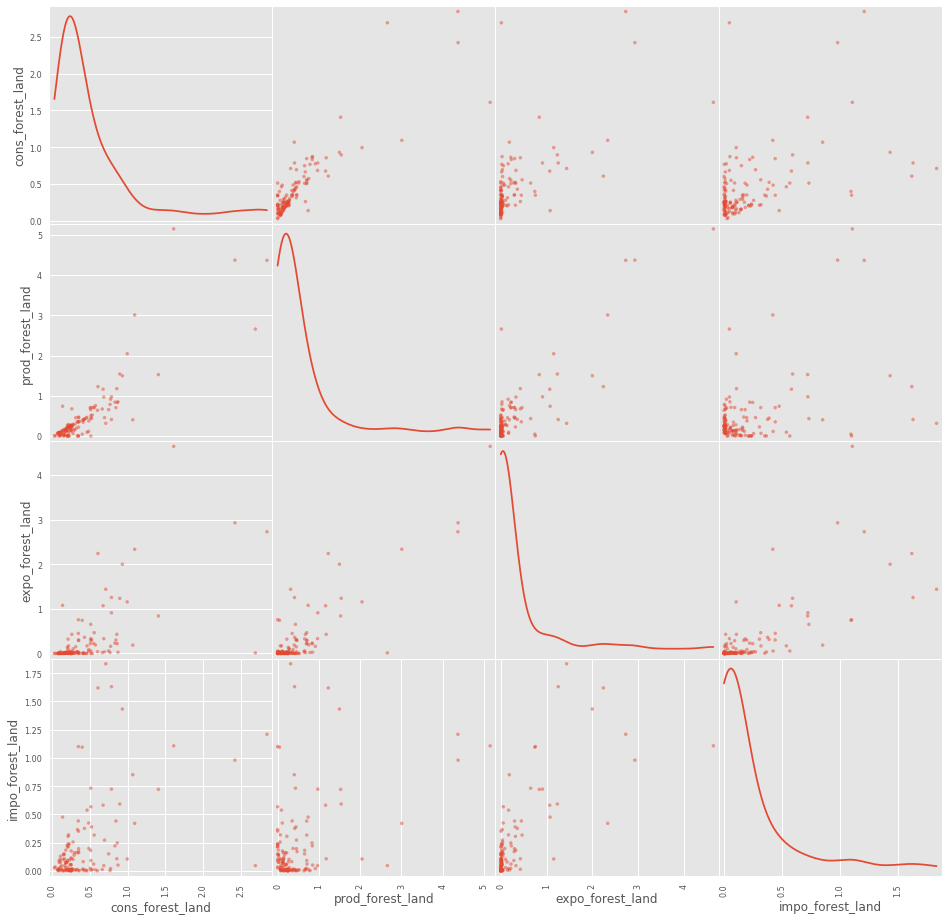

In [265]:
pd.plotting.scatter_matrix(
    c_base[[x for x in c_base.columns if x.split('_')[1] == 'forest']], 
    diagonal='kde',
    figsize=(16,16));

In [266]:
c2014.sort_values('expo_forest_land', ascending=False)\
    [[x for x in c2014 if x[5:11] == 'forest' or x == 'country']].head(6)

,country,cons_forest_land,prod_forest_land,expo_forest_land,impo_forest_land
5112,Sweden,1.610215,5.146953,4.643698,1.106960
2920,Latvia,2.421410,4.370627,2.929114,0.979896
1673,Estonia,2.845913,4.365336,2.728742,1.209319
918,Canada,1.093311,3.008104,2.335764,0.420970
346,Austria,0.606397,1.227403,2.240564,1.619558
4821,Slovenia,0.930163,1.497492,1.999850,1.432522


* There is a large variation in Forest land between countries.  A few countries appear to be both large importers and exporters of forest products, and a couple of countries are very large exporters of forest products  The largest propostional exporters of forest products appear to be The Scandanavian Countries, The Baltic States, and Canada.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


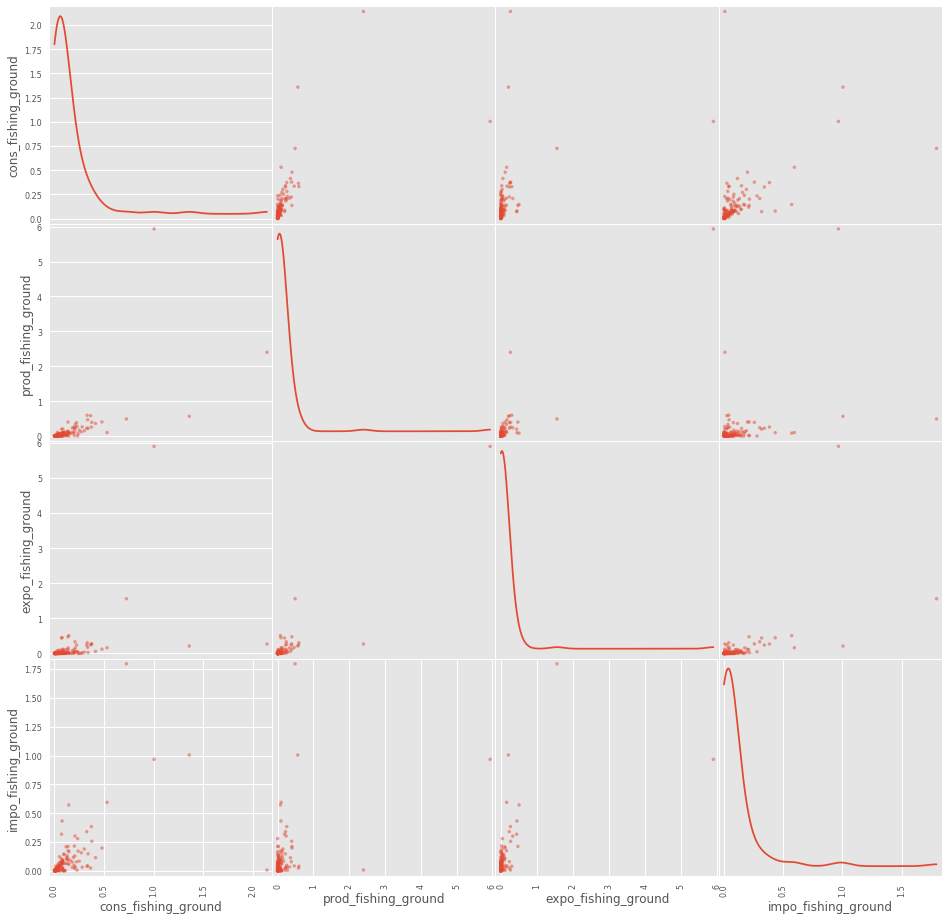

In [267]:
pd.plotting.scatter_matrix(
    c_base[[x for x in c_base.columns if x.split('_')[1] == 'fishing']], 
    diagonal='kde',
    figsize=(16,16));

In [268]:
c2014.sort_values('prod_fishing_ground', ascending=False)\
    [[x for x in c2014 if x[5:12] == 'fishing' or x == 'country']].head(6)

,country,cons_fishing_ground,prod_fishing_ground,expo_fishing_ground,impo_fishing_ground
3986,Norway,1.003321,5.937354,5.900792,0.966759
668,Belize,2.139277,2.399368,0.267798,0.007707
4094,Panama,0.329823,0.595746,0.306258,0.040335
4224,Peru,0.364451,0.582585,0.242907,0.024773
1727,Fiji,1.357715,0.564375,0.211101,1.004441
1477,Denmark,0.725167,0.489419,1.559244,1.794993


* Norway And Belize have the most productive fisharies.  Norway appears to export most of it's fish products; while Belize consumes most of them domestically.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


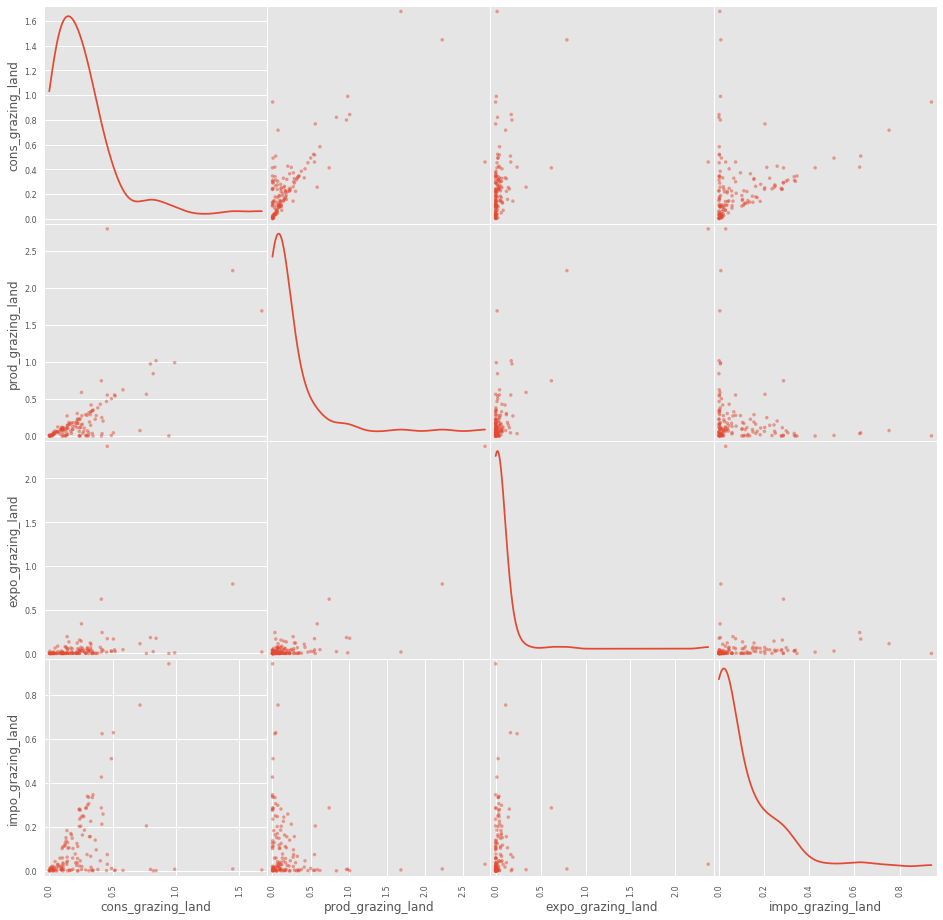

In [269]:
pd.plotting.scatter_matrix(
    c_base[[x for x in c_base.columns if x.split('_')[1] == 'grazing']], 
    diagonal='kde',
    figsize=(16,16));

In [270]:
c2014.sort_values('prod_grazing_land', ascending=False)\
    [[x for x in c2014 if x[5:12] == 'grazing' or x == 'country']].head(6)

,country,cons_grazing_land,prod_grazing_land,expo_grazing_land,impo_grazing_land
292,Australia,0.458460,2.793348,2.365147,0.030259
4170,Paraguay,1.446685,2.231047,0.793065,0.008703
613,Bolivia,1.676006,1.687909,0.016158,0.004256
238,Argentina,0.842534,1.015003,0.173485,0.001016
6137,South Sudan,0.989306,0.989064,0.007062,0.007303
667,Brazil,0.798116,0.972522,0.181163,0.006757


* Australia stands an an outlier in exporting products derived fromn grazing land.  There is also a cluster of Latin American countries that produce large amounts of grazing products for domestic consumption, as is generally the trend. There are also a group of small wealthy countries, and island nations; which are large importers of grazing products.

* Otherwise countries which consume more grazing products tend to also be countries which produce as well.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


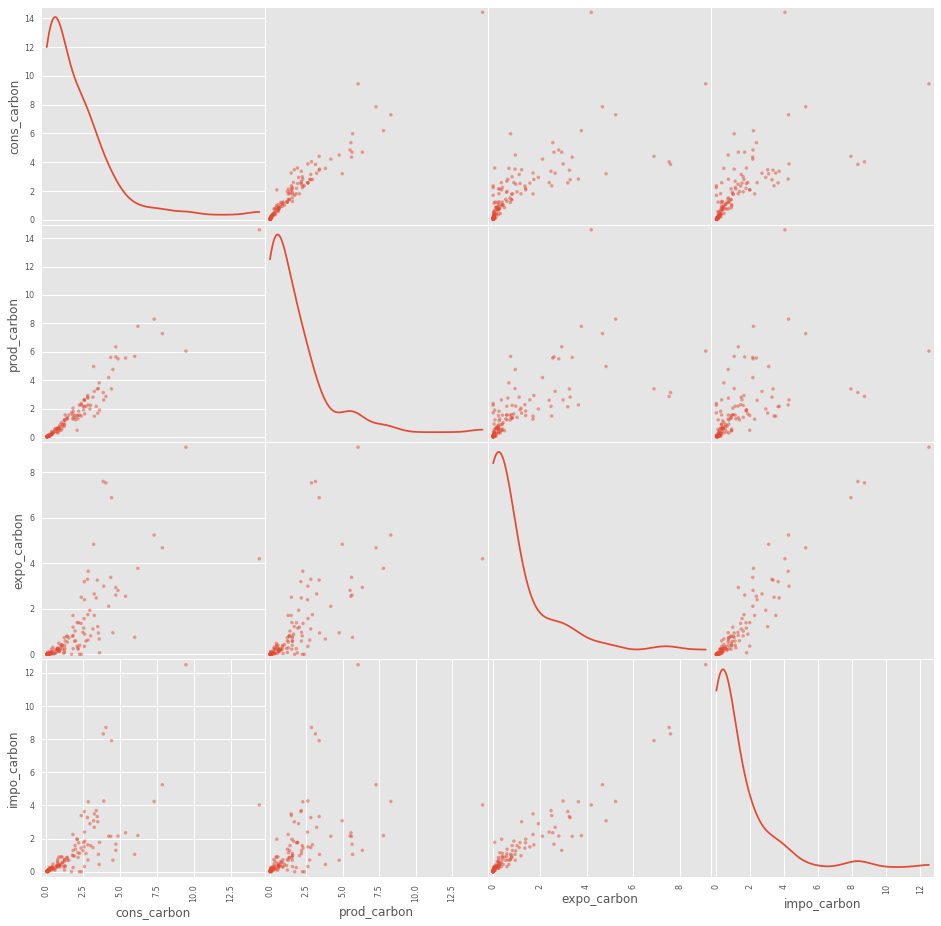

In [271]:
pd.plotting.scatter_matrix(
    c_base[[x for x in c_base.columns if x.split('_')[1] == 'carbon']], 
    diagonal='kde',
    figsize=(16,16));

In [272]:
c2014.sort_values('prod_carbon', ascending=False)\
    [[x for x in c2014 if x[5:11] == 'carbon' or x == 'country']].head(12)

,country,cons_carbon,prod_carbon,expo_carbon,impo_carbon
4490,Qatar,14.414153,14.583844,4.201580,4.031889
425,Bahrain,7.296194,8.298394,5.246379,4.244179
2897,Kuwait,6.196214,7.792683,3.780110,2.183641
5553,United Arab Emirates,7.853406,7.283282,4.684528,5.254652
4744,Saudi Arabia,4.700115,6.345652,2.938060,1.292524
6111,Luxembourg,9.447716,6.053588,9.106821,12.500949
5715,United States of America,5.977441,5.676109,0.746411,1.047743
292,Australia,4.700067,5.641144,2.604521,1.663444
702,Brunei Darussalam,4.357838,5.604681,3.383934,2.137091
918,Canada,5.361607,5.562086,2.553032,2.352553


* Not that this should come as a suprise, but the 5 largest proportional producers of Carbon products are on the Arabian penisulia.

* With a total of 35 parameters and only 140 countrties, we are likley to run into the curse of dimensionality; to combat this, we will first consolidate all the food catagories (fishing, grazing, and crop) into a single catagory.  We will also consolidate the forest and carbon catagory; since these product types are both derived from natural resources.  We will end up with three catagories.  This is a bit of a generalization since not all crops are used for food, and forest products are not necessarily the same as oil, but it should be good enough to get the picture.
>* Resource
>* Food
>* Industry

In [273]:
df_comb.columns

Index(['country', 'year', 'cons_total', 'prod_total', 'expo_total',
       'impo_total', 'population', 'cons_food', 'cons_resource',
       'cons_industry', 'prod_food', 'prod_resource', 'prod_industry',
       'impo_food', 'impo_resource', 'expo_food', 'expo_resource', 'gdp'],
      dtype='object')

In [274]:
df_comb = full_df.copy()

for colt in ['cons_{}', 'prod_{}', 'impo_{}', 'expo_{}']:
    df_comb[colt.format('food')] = \
        df_comb[colt.format('crop_land')] + \
        df_comb[colt.format('grazing_land')] + \
        df_comb[colt.format('fishing_ground')]
    df_comb[colt.format('resource')] = \
        df_comb[colt.format('forest_land')] +\
        df_comb[colt.format('carbon')]
    df_comb[colt.format('industry')] = full_df[colt.format('built_up_land')]
    df_comb.drop([x for x in full_df.columns if x[:5] == colt[:5] and x[-5:] != 'total'], axis=1, inplace=True)
df_comb.drop(["impo_industry", "expo_industry", 'UN_region', 'UN_subregion'], axis=1, inplace=True)
df_comb['gdp'] = df_comb["Percapita GDP (2010 USD)"]
df_comb['population'] = df_comb["population"] / df_comb['population'].max()
df_comb.drop("Percapita GDP (2010 USD)", axis=1, inplace=True)

In [275]:
df_comb[df_comb['gdp'].fillna('A') == "A"]['country'].unique()

array(['Afghanistan', 'Albania', 'Angola', 'Barbados', 'Bhutan', 'Cuba',
       'El Salvador', 'Equatorial Guinea', 'Estonia', 'Gambia', 'Germany',
       'Bosnia and Herzegovina', 'Guadeloupe', 'Guinea', 'Haiti',
       'Croatia', 'Ireland', 'Jordan',
       "Korea, Democratic People's Republic of", 'Latvia',
       "Lao People's Democratic Republic", 'Lebanon',
       'Libyan Arab Jamahiriya', 'Lithuania', 'Mali', 'Malta',
       'Mozambique', 'Moldova', 'New Zealand', 'Poland', 'Guinea-Bissau',
       'Eritrea', 'Qatar', 'Romania', 'Serbia and Montenegro',
       'Saint Lucia', 'Slovenia', 'Somalia', 'Sudan (former)',
       'Switzerland', 'Syrian Arab Republic',
       'Tanzania, United Republic of', 'Tunisia', 'Uganda', 'Viet Nam',
       'Yemen'], dtype=object)

In [276]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 18 columns):
country          6324 non-null object
year             6324 non-null int64
cons_total       6324 non-null float64
prod_total       6324 non-null float64
expo_total       6324 non-null float64
impo_total       6324 non-null float64
population       6324 non-null float64
cons_food        6324 non-null float64
cons_resource    6324 non-null float64
cons_industry    6324 non-null float64
prod_food        6324 non-null float64
prod_resource    6324 non-null float64
prod_industry    6324 non-null float64
impo_food        6324 non-null float64
impo_resource    6324 non-null float64
expo_food        6324 non-null float64
expo_resource    6324 non-null float64
gdp              5459 non-null float64
dtypes: float64(16), int64(1), object(1)
memory usage: 889.4+ KB


## Modeling and Evaluation 1 -- 10
* Train and adjust parameters

* The first thing we can do is try to cluster countries by imports
* Since there are Several catagories here, we will go over the first catagory in detail and derive a function to analyze the remaining catagories in more detail

In [277]:
from sklearn.cluster import KMeans

In [278]:
from sklearn.decomposition import PCA

In [279]:
consume_df = df_comb[[col for col in df_comb.columns if col[:4] == 'cons' or len(col.split('_')) == 1]]\
    .query("year == 2010").set_index('country').drop('year', axis=1)

In [280]:
consume_df['population'] = consume_df['population'] / consume_df['population'].max()
consume_df['gdp'] = consume_df['gdp'] / consume_df['gdp'].max()
consume_df.loc[consume_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

In [281]:
model = KMeans(5)

In [282]:
model.fit(consume_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [283]:
pca = PCA(n_components=2)

In [284]:
consume_2d = pca.fit_transform(consume_df)
consume_2d = np.insert(consume_2d, 2, model.labels_, axis=1)

In [285]:
colors = ["black", 'Red', 'violet', 'green', 'orange', 'cyan', 'gold', 'silver']

In [286]:
consume_df['label'] = model.labels_

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


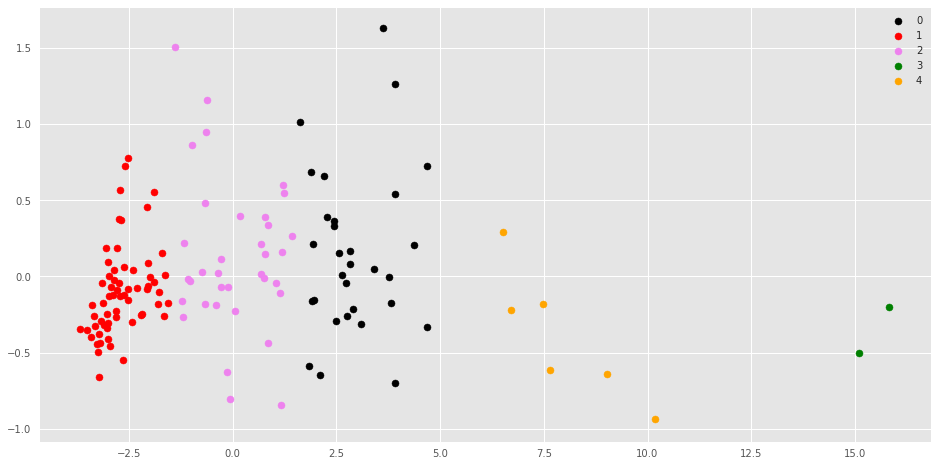

In [287]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
for cls, color in enumerate(colors[:5]):
    cons_tmp = consume_2d[consume_2d[:,2] == cls]
    ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label=cls);
ax.legend();

* There are some pretty obvious clusters there, but the top two values are kind of outliers.  Let's look at the data to see how everything was segmented

In [288]:
consume_df[consume_df['label'] == 4]

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Australia,8.337228,0.003198,1.686978,6.587065,0.063184,0.494204,4
Bahrain,10.676807,0.000182,0.996076,9.599023,0.081709,0.197419,4
Canada,8.306780,0.004925,1.292922,6.954939,0.058919,0.452032,4
Kuwait,8.911158,0.000441,1.016940,7.737484,0.156734,0.366766,4
United Arab Emirates,9.872298,0.001202,1.163657,8.708642,0.000000,0.333912,4
United States of America,8.907719,0.044717,1.378013,7.449664,0.080043,0.460857,4


In [289]:
consume_df[consume_df['label'] == 0]

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Austria,6.217916,0.001211,1.201551,4.874149,0.142216,0.446415,0
Bahamas,4.947813,0.000052,1.913653,2.996234,0.037926,0.208847,0
Brunei Darussalam,4.740897,0.000057,0.597183,4.118011,0.025703,0.335999,0
Denmark,6.775480,0.000801,2.216018,4.347312,0.212151,0.552960,0
Estonia,6.083304,0.000192,0.699419,5.331305,0.052579,0.139462,0
France,5.254434,0.009091,1.401194,3.682170,0.171070,0.388357,0
Germany,5.432812,0.011607,1.090999,4.198958,0.142856,0.398091,0
Greece,5.259986,0.001613,1.662921,3.541129,0.055937,0.256445,0
Ireland,5.034511,0.000666,1.631159,3.311110,0.092242,0.463696,0


In [290]:
consume_df[consume_df['label'] == 3].sample(7)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [291]:
consume_df[consume_df['label'] == 2].sample(5)

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Paraguay,3.364472,0.000896,1.834757,1.404131,0.125584,0.030730,2
Bolivia,2.898670,0.001431,2.087198,0.756429,0.055043,0.018874,2
Guyana,2.619154,0.000109,0.861631,1.690833,0.066690,0.029009,2
Thailand,2.452787,0.009624,0.731784,1.653369,0.067635,0.048352,2
Libyan Arab Jamahiriya,4.329472,0.000904,1.197144,3.114255,0.018073,0.115473,2


In [292]:
consume_df[consume_df['label'] == 1].sample(5)

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Zimbabwe,1.241330,0.002017,0.573627,0.647160,0.020544,0.006859,1
Zambia,0.876873,0.002008,0.362691,0.472801,0.041380,0.013940,1
Burkina Faso,1.304423,0.002256,0.772976,0.468948,0.062499,0.005482,1
Jordan,2.024622,0.000941,0.666878,1.274291,0.083452,0.035052,1
Myanmar,1.557374,0.007465,1.025754,0.403170,0.128450,0.009410,1


* It looks like The 4 clusters are as follows:
>* Class 3: Exteremly Large Consumers very wealthy countries
>* Class 2: Large Consumers - Resource Rich Developed Countries
>* Class 0: Medium-large Consumers - Primarily Industralized, but not resource rich countries
>* Class 4: Resource rich nations and semi-industralized nations
>* Class 1: Small Consumers and Developing Nations

In [293]:
colors

['black', 'Red', 'violet', 'green', 'orange', 'cyan', 'gold', 'silver']

In [294]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [307]:
def plot_kmean(df_comb=df_comb, mtype='', n_clusters=5, year=2010):
    _df = df_comb[[col for col in df_comb.columns if col[:4] == mtype or len(col.split('_')) == 1]]\
        .query("year == {}".format(year)).set_index('country').drop('year', axis=1)

    _df['population'] = _df['population'] / _df['population'].max()
    _df['gdp'] = _df['gdp'] / _df['gdp'].max()
    _df.loc[_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

    kmodel = KMeans(n_clusters)
    kmodel.fit(_df)
    
    score = silhouette_score(_df, kmodel.labels_, metric='euclidean')
    print(score)

    pca = PCA(n_components=2)

    _2df = pca.fit_transform(_df)
    _2df = np.insert(_2df, 2, kmodel.labels_, axis=1)
    _df.loc[:,'label'] = kmodel.labels_

    fig, ax = plt.subplots(1,1, figsize=(16,8))
    for cls, color in enumerate(colors[:n_clusters]):
        cons_tmp = _2df[_2df[:,2] == cls]
        ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label="class = {}".format(cls));
    ax.legend()

    return _df

In [308]:
pca.components_

array([[  7.42762527e-01,  -7.87220321e-04,   7.55203326e-02,
          6.63828699e-01,   3.41349711e-03,   4.38143188e-02],
       [  3.43944930e-01,  -1.19278080e-02,   8.01878389e-01,
         -4.81415767e-01,   2.34823212e-02,   7.89816579e-02]])

0.621577894917


/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


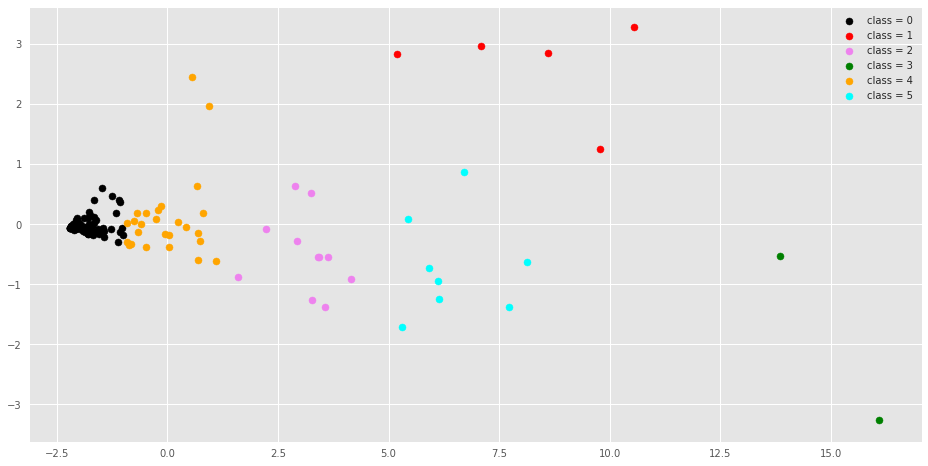

In [309]:
export_df = plot_kmean(mtype='expo', n_clusters=6)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


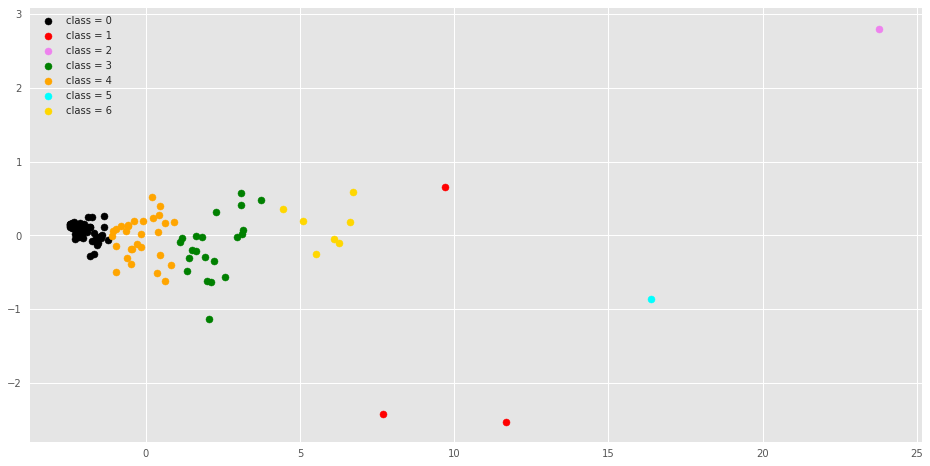

In [298]:
import_df = plot_kmean(mtype='impo', n_clusters=7)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


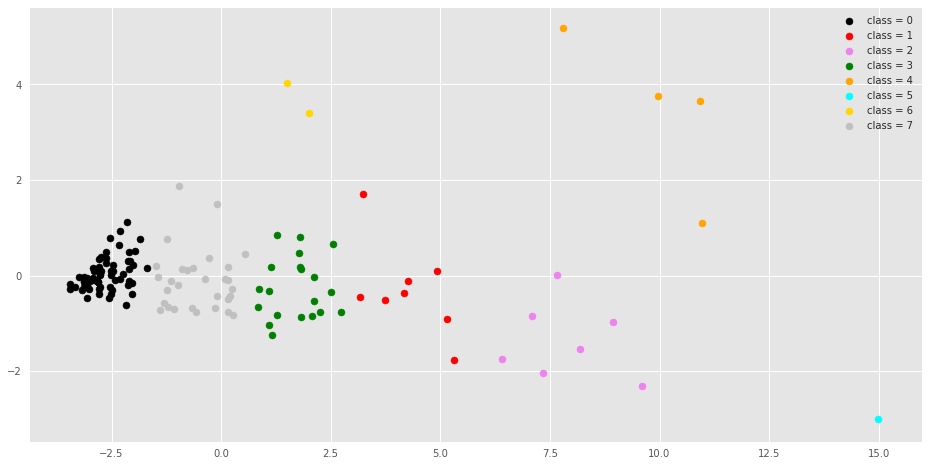

In [299]:
prodction_df = plot_kmean(mtype='prod', n_clusters=8, year=2010)

In [300]:
comb_df['']

NameError: name 'comb_df' is not defined

In [179]:
df_comb.sample(3).T

,5336,2680,2670
country,Togo,Jordan,Jordan
year,1971,1975,1965
cons_total,1.24096,0.903071,1.74686
prod_total,1.26076,0.612627,1.37666
expo_total,0.194423,0.310496,0.330965
impo_total,0.174619,0.60094,0.701165
population,0.000300862,0.000273198,0.000154147
cons_food,0.468351,0.379186,1.09102
cons_resource,0.758898,0.506661,0.561119
cons_industry,0.0137086,0.0172231,0.0947199


In [180]:
df_comb.sample(4)

,country,year,cons_total,prod_total,expo_total,impo_total,population,cons_food,cons_resource,cons_industry,prod_food,prod_resource,prod_industry,impo_food,impo_resource,expo_food,expo_resource,gdp
4976,Spain,1997,4.936376,4.057921,1.636809,2.515263,0.005505,1.778900,3.120003,0.037472,1.523595,2.496854,0.037472,0.793080,1.722183,0.537775,1.099033,25007.900
1808,Gambia,1976,1.012503,1.404485,0.756164,0.364181,0.000074,0.641767,0.308350,0.062386,1.050445,0.291655,0.062386,0.229257,0.134923,0.637935,0.118229,535.396
4479,Qatar,2003,9.585215,17.372977,12.294401,4.506639,0.000092,1.312271,8.220719,0.052225,0.275668,17.045084,0.052225,1.170862,3.335777,0.134258,12.160143,60460.400
3053,Lesotho,1990,1.490059,1.374382,0.130619,0.246296,0.000220,0.818841,0.651187,0.020031,0.735196,0.619155,0.020031,0.200395,0.045901,0.116750,0.013869,681.785


## Modeling and Evaluation 2 -- 10 
* Evaluate and Compare

In [234]:
def plot_dbscan(df_comb=df_comb, mtype='', n_clusters=5, year=2010):
    _df = df_comb[[col for col in df_comb.columns if col[:4] == mtype or len(col.split('_')) == 1]]\
        .query("year == {}".format(year)).set_index('country').drop('year', axis=1)

    _df['population'] = _df['population'] / _df['population'].max()
    _df['gdp'] = _df['gdp'] / _df['gdp'].max()
    _df.loc[_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

    kmodel = DBSCAN(n_clusters)
    kmodel.fit(_df)

    pca = PCA(n_components=2)

    _2df = pca.fit_transform(_df)
    _2df = np.insert(_2df, 2, kmodel.labels_, axis=1)
    _df.loc[:,'label'] = kmodel.labels_

    fig, ax = plt.subplots(1,1, figsize=(16,8))
    for cls, color in enumerate(colors[:n_clusters]):
        cons_tmp = _2df[_2df[:,2] == cls]
        ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label="class = {}".format(cls));
    ax.legend()

    return _df

In [235]:
prodction_df = plot_dbscan(mtype='prod', n_clusters=10, year=2010)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

## DBscan Failed

DBSCAN fails:
* in cases of varying density clusters.
* in cases of high dimensional data.

Our data has both, and so DBSCAN only found 1 giant cluster, even when searching for 5+.

In [183]:
def plot_ac(df_comb=df_comb, mtype='', n_clusters=5, year=2010):
    _df = df_comb[[col for col in df_comb.columns if col[:4] == mtype or len(col.split('_')) == 1]]\
        .query("year == {}".format(year)).set_index('country').drop('year', axis=1)

    _df['population'] = _df['population'] / _df['population'].max()
    _df['gdp'] = _df['gdp'] / _df['gdp'].max()
    _df.loc[_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

    kmodel = AgglomerativeClustering(n_clusters)
    kmodel.fit(_df)

    pca = PCA(n_components=2)

    _2df = pca.fit_transform(_df)
    _2df = np.insert(_2df, 2, kmodel.labels_, axis=1)
    _df.loc[:,'label'] = kmodel.labels_

    fig, ax = plt.subplots(1,1, figsize=(16,8))
    for cls, color in enumerate(colors[:n_clusters]):
        cons_tmp = _2df[_2df[:,2] == cls]
        ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label="class = {}".format(cls));
    ax.legend()

    return _df

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


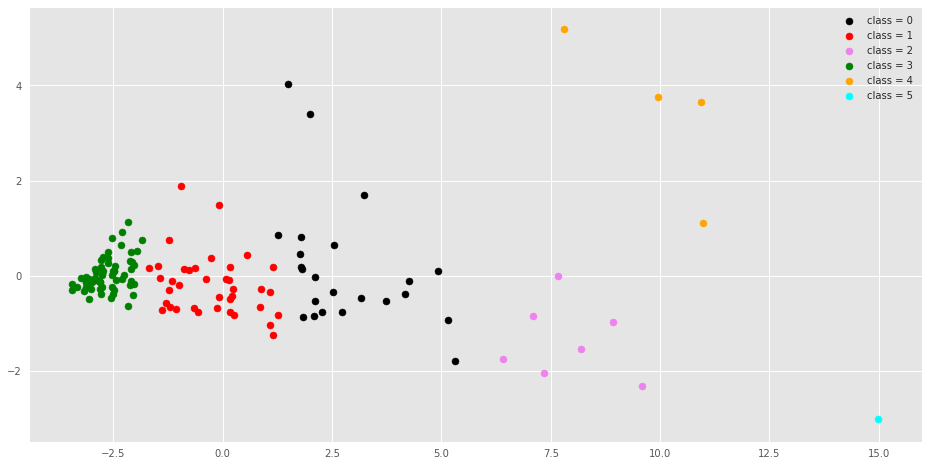

In [184]:
prodction_df = plot_ac(mtype='prod', n_clusters=6, year=2010)

In [202]:
footprint_df['year'].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991])

In [206]:
for year in df_comb['year'].unique():
    df_comb.loc[(df_comb['gdp'].fillna('NA') == 'NA') & (df_comb['year'] == year), 'gdp'] \
            = df_comb[df_comb['year'] == year]['gdp'].mean()

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [207]:
prodction_df = plot_kmean(mtype='prod', n_clusters=6, year=2010)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [209]:
consume_df = df_comb[[col for col in df_comb.columns if col[:4] == 'cons' or len(col.split('_')) == 1]]\
    .query("year == 1961").set_index('country').drop('year', axis=1)

In [210]:
consume_df['population'] = consume_df['population'] / consume_df['population'].max()
consume_df['gdp'] = consume_df['gdp'] / consume_df['gdp'].max()
consume_df.loc[consume_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [211]:
model = KMeans(5)

In [212]:
model.fit(consume_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [213]:
pca = PCA(n_components=2)

In [214]:
consume_2d = pca.fit_transform(consume_df)
consume_2d = np.insert(consume_2d, 2, model.labels_, axis=1)

In [215]:
colors = ["black", 'Red', 'violet', 'green', 'orange', 'cyan', 'gold', 'silver']

In [216]:
consume_df['label'] = model.labels_

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


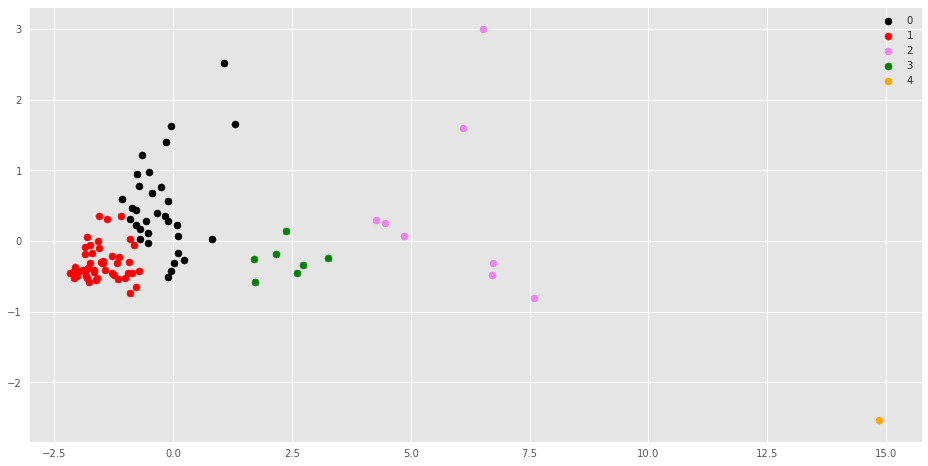

In [217]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
for cls, color in enumerate(colors[:5]):
    cons_tmp = consume_2d[consume_2d[:,2] == cls]
    ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label=cls);
ax.legend();

In [218]:
label_order = consume_df.groupby('label').agg({"cons_total" : 'mean', 'gdp' : 'count'}).sort_values('gdp').index

In [219]:
consume_df[consume_df['label'] == label_order[0]]

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Luxembourg,13.304813,0.000129,1.584944,11.55879,0.16108,1.0,4


In [220]:
consume_df[consume_df['label'] == label_order[1]]

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Austria,3.605339,0.002311,1.125782,2.394784,0.084774,0.490799,3
France,4.229499,0.015120,1.565637,2.603582,0.060280,0.485306,3
Germany,4.272328,0.023962,1.137442,3.073695,0.061191,0.191141,3
Netherlands,3.531832,0.003764,0.876170,2.590874,0.064788,0.580903,3
New Zealand,4.827793,0.000788,1.449757,3.370710,0.007326,0.191141,3
Poland,3.996881,0.009801,1.284063,2.660650,0.052169,0.191141,3
Switzerland,4.396812,0.001754,1.253408,3.088283,0.055120,0.191141,3


In [221]:
consume_df[consume_df['label'] == label_order[2]].sample(7)

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Australia,7.470904,0.003413,3.389320,4.057441,0.024143,0.695950,2
Norway,8.146321,0.001174,4.575302,3.531924,0.039095,0.877105,2
Canada,7.438794,0.005950,1.848535,5.573707,0.016552,0.640951,2
Sweden,7.503927,0.002448,1.953377,5.456848,0.093702,0.684790,2
Belgium,5.750656,0.002966,2.004186,3.644035,0.102436,0.495346,2
Denmark,5.887291,0.001500,1.997414,3.765481,0.124397,0.798915,2
United States of America,8.053772,0.061487,1.735348,6.280768,0.037656,0.615126,2


In [222]:
consume_df[consume_df['label'] == label_order[3]].sample(5)

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Brazil,2.405120,0.024294,1.481224,0.878201,0.045696,0.131622,0
Malta,1.796042,0.000101,1.100223,0.669194,0.026626,0.191141,0
Mexico,1.846639,0.012811,1.076742,0.748945,0.020952,0.134594,0
Italy,2.425363,0.016287,1.123678,1.266964,0.034721,0.419168,0
Peru,2.724637,0.003366,2.333299,0.334866,0.056472,0.100513,0


In [223]:
consume_df[consume_df['label'] == label_order[4]].sample(5)

,cons_total,population,cons_food,cons_resource,cons_industry,gdp,label
country,,,,,,,
Côte d'Ivoire,1.557663,0.001171,0.658987,0.873130,0.025546,0.045805,1
"Korea, Democratic People's Republic of",1.267143,0.003794,0.450573,0.772774,0.043796,0.191141,1
Benin,1.317044,0.000802,0.430094,0.867265,0.019685,0.018993,1
El Salvador,1.125719,0.000925,0.544558,0.541437,0.039724,0.191141,1
Cameroon,1.300072,0.001780,0.671435,0.613950,0.014687,0.034011,1


There's not too much difference betweent the two, maybe look at the 3 points around 5.0 to see why one algorithm thinks they're in the cluster to the right vs the left.

## Modeling and Evaluation 3 -- 10	
* Visualize Results

## Modeling and Evaluation 4 -- 20
* Summarize the Ramifications

## Deployment 	10	
* Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

## Exceptional Work	10	
* You have free reign to provide additional analyses or combine analyses.